# Analysis of the OECD 2000 Sanctions on popular offshore entity destinations

This notebook contains all of our analyses done regarding the impact of the 2000 OECD sanctions on notable offshore wealth hubs. These include: 

- Looking at the frequency of incorporations and inactivations before and after the sanctions using a time series
- Looking at the top 10 most popular jurisdictions in terms of their percentage of total incorporations on the blacklist from 2000 - 2003 and 2004 - 2007 
- Looking at the top 10 blacklisted jurisdictions (with some exceptions) in terms of their percentage of total incorporations from before 2000 and after 2007

In [1]:
## importing packages and libraries that we've used in class
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
from matplotlib.patches import Patch


## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



## Functions used 

In [2]:
## Function to normalize jurisdiction_description as before

def normalize_jurisdiction(name):
    if pd.isna(name):
        return ''
    # Lowercase
    name = name.lower()
    
    # Strip whitespace and newlines
    name = name.strip().replace('\n', '')
    
    # Replace 'british anguilla' with 'anguilla'
    if 'british anguilla' in name:
        name = name.replace('british anguilla', 'anguilla')
    
    # Replace 'st.' with 'saint'
    name = name.replace('st.', 'saint')
    # Also replace 'st ' with 'saint ' to catch "St Kitts" without dot
    name = name.replace('st ', 'saint ')
    
    # Replace & with and
    name = name.replace('&', 'and')
    
    # Replace multiple spaces with single space, then strip again
    name = ' '.join(name.split())
    
    # Replace 'u.s.' with 'us'
    name = name.replace('u.s.', 'us')
    
    # Fix specific misspellings / variants
    # Cook Islands might appear as 'cookislands', so fix it:
    if 'cookislands' in name:
        name = name.replace('cookislands', 'cook islands')

    # Normalize nevis alone to full name if possible
    if name == 'nevis':
        name = 'saint kitts and nevis'
    
    return name

###############################################################

## Function to create a color map for jurisdictions
def color_map(jurisdictions, blacklist, highlight_color='red', default_color='gray'):
    return [highlight_color if j in blacklist else default_color for j in jurisdictions]



## Rest of the code

In [3]:
dtype_spec = {2:str, 3:str, 6:str, 7:str, 10:str, 11:str, 12:str, 13:str, 14:str, 15:str, 16:str, 17:str, 20:str}
entities_df = pd.read_csv("nodes-entities.csv", dtype=dtype_spec)

In [4]:
entities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814344 entries, 0 to 814343
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   node_id                   814344 non-null  int64  
 1   name                      814315 non-null  object 
 2   original_name             389522 non-null  object 
 3   former_name               6837 non-null    object 
 4   jurisdiction              806780 non-null  object 
 5   jurisdiction_description  806782 non-null  object 
 6   company_type              138751 non-null  object 
 7   address                   299323 non-null  object 
 8   internal_id               389522 non-null  float64
 9   incorporation_date        788470 non-null  object 
 10  inactivation_date         144773 non-null  object 
 11  struck_off_date           343843 non-null  object 
 12  dorm_date                 20207 non-null   object 
 13  status                    358036 non-null  o

In [5]:
entities_df.jurisdiction_description.unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'Bahamas', 'British Anguilla',
       'Seychelles', 'Niue', 'Uruguay', 'British Virgin Islands',
       'Hong Kong', 'New Zealand', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica', 'Undetermined', 'Cayman',
       'Recorded in leaked files as "fund"', 'Labuan', 'Marshall Islands',
       'Mauritius', 'St. Lucia', 'Malaysia', 'Dubai', 'Vanuatu',
       'Cook Islands', 'Bermuda', 'Brunei', 'Liberia',
       'United States Of America', 'China', 'Thailand', 'Netherlands',
       'Ireland', 'Aruba', 'United Arab Emirates', 'Antigua and Barbuda',
       'Anguilla', 'Netherlands Antilles', 'Barbados', 'Lebanon',
       'Cayman Islands', 'Ghana', 'Grenada', 'Guernsey', 'Gibraltar',
       'Isle of Man', 'Saint Kitts and Nevis', 'Liechtenstein',
       'Luxembourg', 'Turks and Caicos Islands',
       'United States of America', 'State of Delaware',
       'Saint Vince

In [6]:
# 1. Normalize status column
entities_df['status_normalized'] = entities_df['status'].str.lower().str.strip()

# 2. Create a boolean column to identify active/open status
entities_df['is_active'] = entities_df['status_normalized'].str.contains('active', na=False) | entities_df['status_normalized'].str.contains('open', na=False)

# 3. Parse date columns to datetime (if not already done)
entities_df['incorporation_date'] = pd.to_datetime(entities_df['incorporation_date'], errors='coerce')
entities_df['inactivation_date'] = pd.to_datetime(entities_df['inactivation_date'], errors='coerce')
entities_df['struck_off_date'] = pd.to_datetime(entities_df['struck_off_date'], errors='coerce')

# 4. Create a unified 'end_date' that prioritizes 'inactivation_date' over 'struck_off_date'
entities_df['end_date'] = entities_df['inactivation_date'].combine_first(entities_df['struck_off_date'])

# 5. Build boolean mask for entities with proper date metadata
has_valid_incorp = entities_df['incorporation_date'].notna()
has_valid_end_date = entities_df['end_date'].notna()

# 6. Filter condition:
# Keep entity if it has incorporation date AND
# (has inactivation/struck_off date OR is active/open)
valid_entities_mask = has_valid_incorp & (has_valid_end_date | entities_df['is_active'])

# 7. Filter dataframe
entities_df_filtered = entities_df[valid_entities_mask].copy()

print(f"Filtered entities count: {entities_df_filtered.shape[0]}")

/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_16413/577356396.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_16413/577356396.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
/var/folders/5x/0sqjbpy13p3gzjlddpxqjtfw0000gn/T/ipykernel_16413/577356396.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


Filtered entities count: 456945


### Filtering to blacklisted jurisdictions that have proper date data to process

In [7]:
# Normalize jurisdiction_description in your dataframe
# Applies the normalize_jurisdiction function to the 'jurisdiction_description' column and stores the result in a new 'jurisdiction_norm' column
entities_df_filtered['jurisdiction_norm'] = entities_df_filtered['jurisdiction_description'].apply(normalize_jurisdiction)

# Example: Normalize your OECD blacklist entries with same function
# Defines a list of raw jurisdiction names that are on the OECD 2000 blacklist
oecd_2000_blacklist_raw = [
    'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Bahrain',
    'Barbados', 'Belize', 'British Virgin Islands', 'Cook Islands', 'Dominica',
    'Gibraltar', 'Grenada', 'Guernsey', 'Isle of Man', 'Jersey', 'Liberia',
    'Liechtenstein', 'Maldives', 'Marshall Islands', 'Monaco', 'Montserrat',
    'Nauru', 'Netherlands Antilles', 'Niue', 'Panama', 'Samoa', 'Seychelles',
    'St. Lucia', 'St. Kitts and Nevis', 'St. Vincent and the Grenadines', 'Tonga',
    'Turks and Caicos Islands', 'U.S. Virgin Islands', 'Vanuatu'
]

# Normalizes each jurisdiction name in the raw blacklist using the normalize_jurisdiction function
oecd_2000_blacklist = [normalize_jurisdiction(c) for c in oecd_2000_blacklist_raw]

# Now you can filter using the normalized column and normalized blacklist:
# Filters the 'entities_df_filtered' DataFrame to include only rows where the 'jurisdiction_norm' is in the 'oecd_2000_blacklist'
blacklist_entities_df = entities_df_filtered[entities_df_filtered['jurisdiction_norm'].isin(oecd_2000_blacklist)].copy()

# Prints the number of entities found in the blacklisted jurisdictions after filtering
print(f"Number of entities in blacklisted jurisdictions with proper date data: {blacklist_entities_df.shape[0]}")

Number of entities in blacklisted jurisdictions with proper date data: 435835


### Line graph for time series of incorporations and inactivations over the years

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Entities in OECD 2000 Blacklist Jurisdictions: Incorporation & Inactivation by Year')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Entities')

(1980.0, 2020.0)

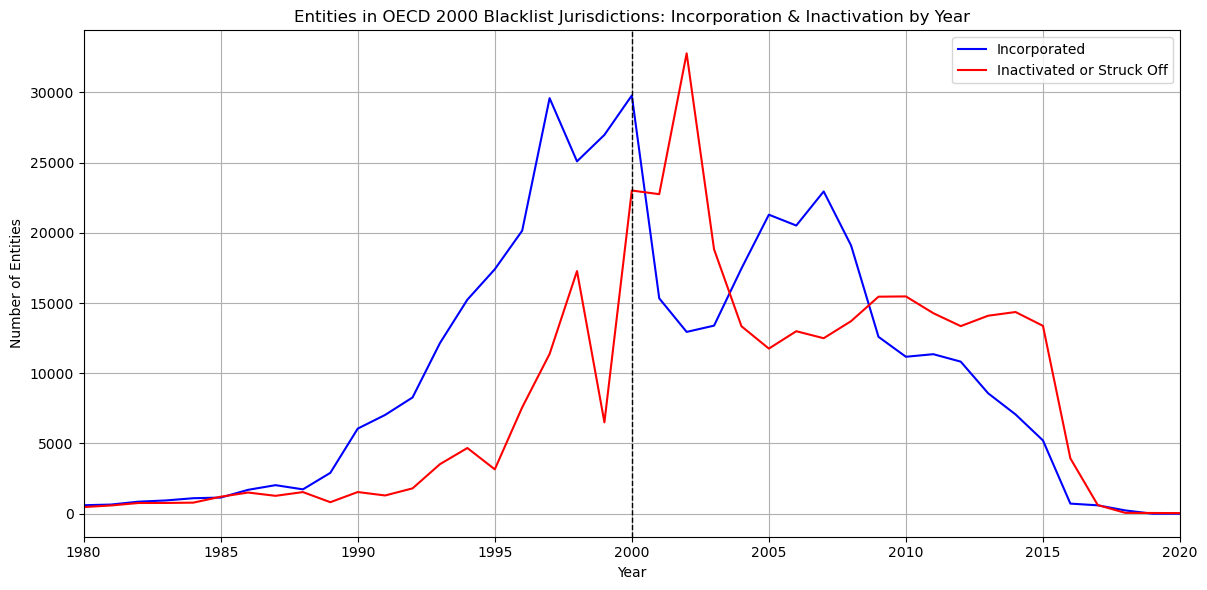

In [8]:
# Extract the incorporation year from the 'incorporation_date' column
blacklist_entities_df['incorp_year'] = blacklist_entities_df['incorporation_date'].dt.year

# Determine the earliest end date by comparing 'inactivation_date' and 'struck_off_date'
# This unified 'end_date' represents when an entity ceased to be active for any reason
blacklist_entities_df['end_date'] = blacklist_entities_df[['inactivation_date', 'struck_off_date']].min(axis=1)
# Extract the year from the 'end_date' column
blacklist_entities_df['end_year'] = blacklist_entities_df['end_date'].dt.year

# Group by incorporation year and count the number of unique entities incorporated each year
# .nunique() counts distinct 'node_id's to avoid double-counting if an entity appears multiple times
# .sort_index() ensures the years are in chronological order
incorp_counts = blacklist_entities_df.groupby('incorp_year')['node_id'].nunique().sort_index()

# Group by end year and count the number of unique entities inactivated or struck off each year
end_counts = blacklist_entities_df.groupby('end_year')['node_id'].nunique().sort_index()

# Plotting the time series data
plt.figure(figsize=(12, 6)) 

# Plot the number of entities incorporated per year
plt.plot(incorp_counts.index, incorp_counts.values, label='Incorporated', color='blue')
# Plot the number of entities inactivated or struck off per year
plt.plot(end_counts.index, end_counts.values, label='Inactivated or Struck Off', color='red')

# Add a vertical dotted line at the year 2000 to mark the OECD sanctions
plt.axvline(x=2000, color='black', linestyle='--', linewidth=1)

# Set the title and labels for the plot
plt.title('Entities in OECD 2000 Blacklist Jurisdictions: Incorporation & Inactivation by Year')
plt.xlabel('Year')
plt.ylabel('Number of Entities')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Set the limits for the x-axis to focus on a specific period
plt.xlim(1980, 2020)
plt.show()

### Bar charts of the top 10 most popular jurisdictions in terms of their percentage of total incorporations on the blacklist from 2000 - 2003 and 2004 - 2007 

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='jurisdiction_norm'>

Text(0.5, 1.0, 'Top 10 OECD Blacklist Jurisdictions for Ended Entities (2000–2003)')

Text(0.5, 0, 'Percent of All Ended Entities (2000-2003)')

Text(0, 0.5, 'Jurisdiction')

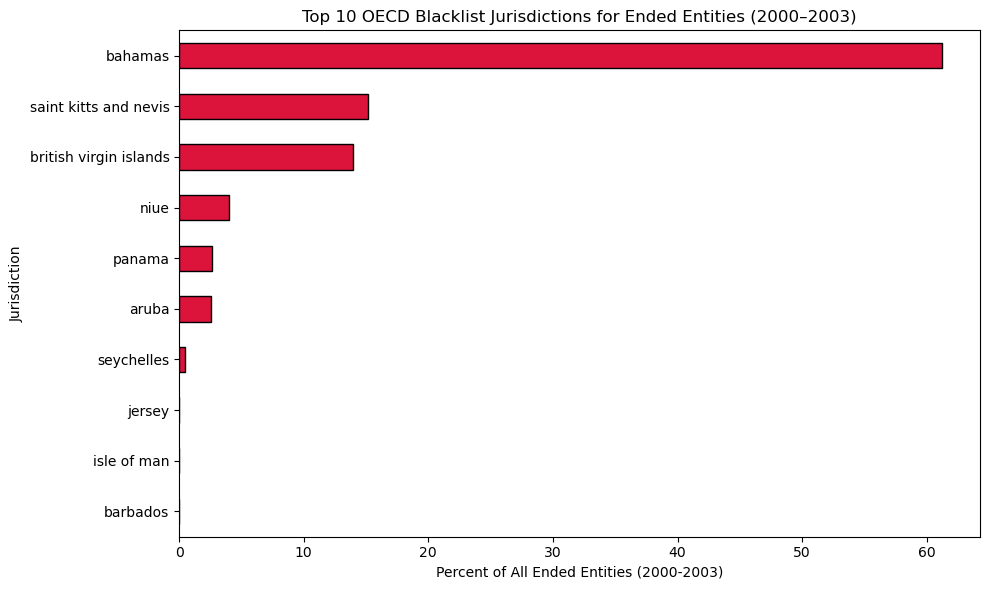

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='jurisdiction_norm'>

Text(0.5, 1.0, 'Top 10 OECD Blacklist Jurisdictions for New Incorporations (2004–2007)')

Text(0.5, 0, 'Percent of all Newly Incorporated Entities (2004-2007)')

Text(0, 0.5, 'Jurisdiction')

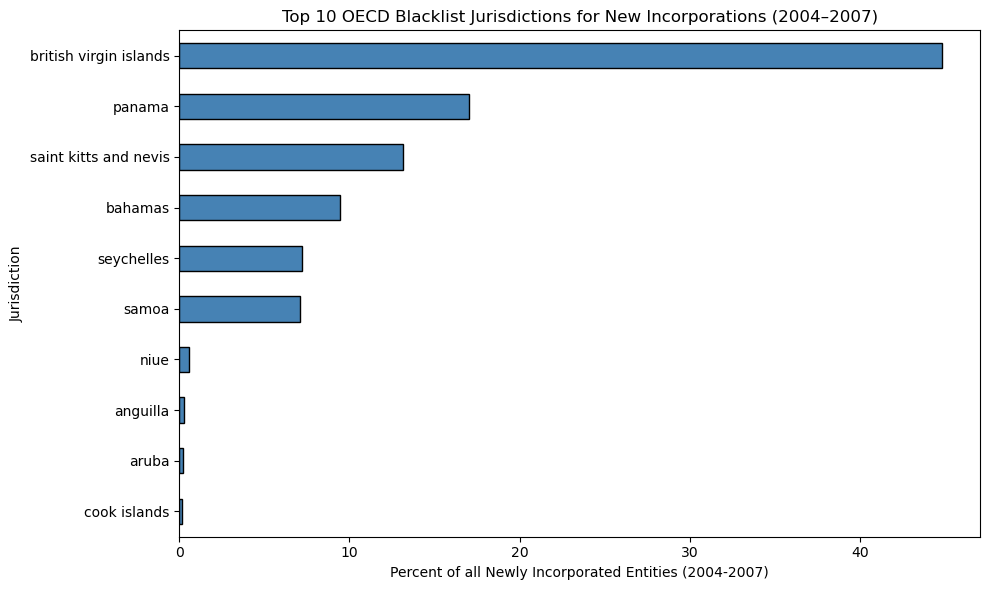

In [9]:

# (Re)compute the year columns
# Extract incorporation year from 'incorporation_date'
blacklist_entities_df['incorp_year'] = blacklist_entities_df['incorporation_date'].dt.year

# Determine the earliest end date from 'inactivation_date' and 'struck_off_date'
blacklist_entities_df['end_date'] = blacklist_entities_df[
    ['inactivation_date', 'struck_off_date']
].min(axis=1)
# Extract end year from the calculated 'end_date'
blacklist_entities_df['end_year'] = blacklist_entities_df['end_date'].dt.year

## PART A: Top 10 % jurisdictions by ENDED entities (2000–2003)

# Filter entities that ended between 2000 and 2003 (inclusive)
ended_00_03 = blacklist_entities_df[
    (blacklist_entities_df['end_year'] >= 2000) &
    (blacklist_entities_df['end_year'] <= 2003)
]

# Count unique entities (node_id) per normalized jurisdiction for the filtered period
ended_counts = ended_00_03.groupby('jurisdiction_norm')['node_id'].nunique()

# Calculate the total number of entities that ended in this period
total_ended = ended_counts.sum()
# Convert counts to percentages of the total ended entities
ended_pct = (ended_counts / total_ended) * 100

# Get the top 10 jurisdictions by percentage of ended entities
ended_top10 = ended_pct.sort_values(ascending=False).head(10)

# Plot horizontal bar chart for top 10 ended jurisdictions
plt.figure(figsize=(10, 6)) # Set figure size
# Create bar plot, sorted for ascending display
ended_top10.sort_values().plot(
    kind='barh', color='crimson', edgecolor='black'
)
plt.title('Top 10 OECD Blacklist Jurisdictions for Ended Entities (2000–2003)') # Set plot title
plt.xlabel('Percent of All Ended Entities (2000-2003)') # Set x-axis label
plt.ylabel('Jurisdiction') # Set y-axis label
plt.tight_layout() # Adjust layout to prevent overlap
plt.show() # Display the plot

## PART B: Top 10 % jurisdictions by NEW INCORPORATIONS (2004–2007)

# Filter entities incorporated between 2004 and 2007 (inclusive)
incorp_04_07 = blacklist_entities_df[
    (blacklist_entities_df['incorp_year'] >= 2004) &
    (blacklist_entities_df['incorp_year'] <= 2007)
]

# Count unique entities (node_id) per normalized jurisdiction for new incorporations
incorp_counts = incorp_04_07.groupby('jurisdiction_norm')['node_id'].nunique()

# Calculate the total number of new incorporations in this period
total_incorp = incorp_counts.sum()
# Convert counts to percentages of the total new incorporations
incorp_pct = (incorp_counts / total_incorp) * 100

# Get the top 10 jurisdictions by percentage of new incorporations
incorp_top10 = incorp_pct.sort_values(ascending=False).head(10)

# Plot horizontal bar chart for top 10 incorporation jurisdictions
plt.figure(figsize=(10, 6)) 

incorp_top10.sort_values().plot(
    kind='barh', color='steelblue', edgecolor='black'
)
plt.title('Top 10 OECD Blacklist Jurisdictions for New Incorporations (2004–2007)') 
plt.xlabel('Percent of all Newly Incorporated Entities (2004-2007)') 
plt.ylabel('Jurisdiction') 
plt.tight_layout() 
plt.show() 

### Bar charts of the top 10 blacklisted jurisdictions (with some exceptions) in terms of their percentage of total incorporations from before 2000 and after 2007

<Axes: ylabel='jurisdiction_norm'>

Text(0.5, 1.0, 'Top 10 Jurisdictions of Incorporation Before 2000')

Text(0.5, 0, 'Percentage of All Entities Incorporated Before 2000')

Text(0, 0.5, 'Jurisdiction')

<Axes: ylabel='jurisdiction_norm'>

Text(0.5, 1.0, 'Top 10 Jurisdictions of Incorporation After 2007')

Text(0.5, 0, 'Percentage of All Entities Incorporated After 2007')

Text(0, 0.5, '')

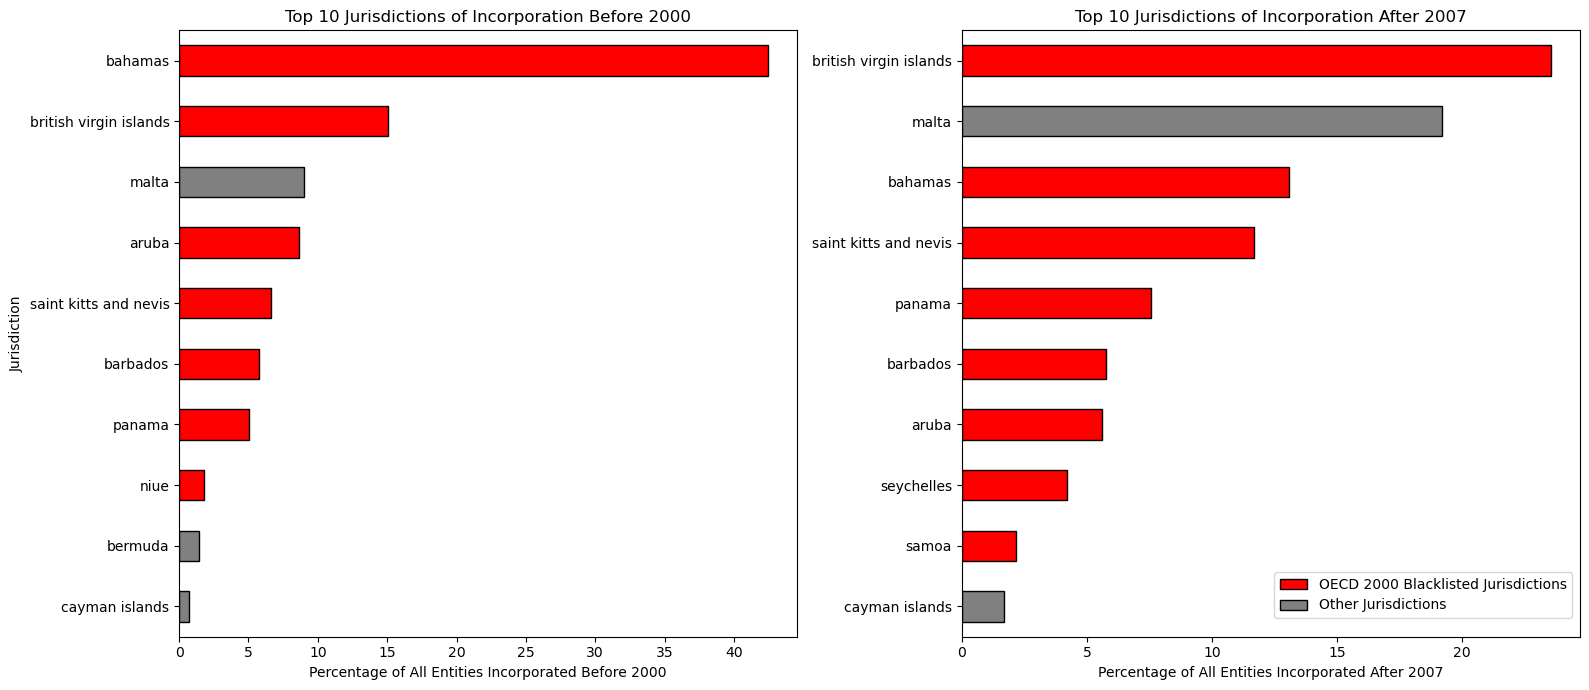

In [10]:
# Convert 'incorporation_date' to datetime, handling errors by setting them to NaT
entities_df['incorporation_date'] = pd.to_datetime(entities_df['incorporation_date'], errors='coerce')
# Create a DataFrame 'entities_with_incorp' with rows where 'incorporation_date' is not NaT
entities_with_incorp = entities_df[entities_df['incorporation_date'].notna()].copy()

# Normalize jurisdiction descriptions
entities_with_incorp['jurisdiction_norm'] = entities_with_incorp['jurisdiction_description'].apply(normalize_jurisdiction)

# Define cutoff years for time period analysis
pre_cutoff = 2000  # Marks end of the 'pre' period
post_cutoff = 2007 # Marks start of the 'post' period

# Extract the incorporation year
entities_with_incorp['incorp_year'] = entities_with_incorp['incorporation_date'].dt.year

# Filter entities for periods before 2000 and after 2007
pre_2000 = entities_with_incorp[entities_with_incorp['incorp_year'] < pre_cutoff] # Entities incorporated before pre_cutoff
post_2007 = entities_with_incorp[entities_with_incorp['incorp_year'] > post_cutoff] # Entities incorporated after post_cutoff


# Calculate total unique entities for each period
total_pre = pre_2000['node_id'].nunique() # Total unique entities before pre_cutoff
total_post = post_2007['node_id'].nunique() # Total unique entities after post_cutoff

# Compute unique entity counts per jurisdiction, excluding 'undetermined'
# Counts for the period before pre_cutoff
pre_counts = (
    pre_2000[pre_2000['jurisdiction_norm'] != 'undetermined']
    .groupby('jurisdiction_norm')['node_id']
    .nunique()
)
# Counts for the period after post_cutoff
post_counts = (
    post_2007[post_2007['jurisdiction_norm'] != 'undetermined']
    .groupby('jurisdiction_norm')['node_id']
    .nunique()
)
# Convert counts to percentages of the total for each period
pre_counts_percent = (pre_counts / total_pre) * 100 # Percentages for pre_cutoff period
post_counts_percent = (post_counts / total_post) * 100 # Percentages for post_cutoff period

# Get the top 10 jurisdictions by percentage for each period
pre_counts_percent = pre_counts_percent.sort_values(ascending=False).head(10) # Top 10 before pre_cutoff
post_counts_percent = post_counts_percent.sort_values(ascending=False).head(10) # Top 10 after post_cutoff


# Prepare color maps for bar charts based on OECD blacklist status
blacklist_set = set(oecd_2000_blacklist) # Set for efficient lookup of blacklisted jurisdictions

# Assign colors for pre-2000 jurisdictions (e.g., red if blacklisted, gray otherwise)
pre_colors = color_map(pre_counts_percent.index, blacklist_set)
# Assign colors for post-2007 jurisdictions
post_colors = color_map(post_counts_percent.index, blacklist_set)

# Plotting the results
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)

## Plot for top 10 jurisdictions before 2000
pre_counts_percent.plot(
    kind='barh',
    ax=axes[0], 
    color=pre_colors, 
    edgecolor='black' 
)
axes[0].invert_yaxis() # Display highest percentage at the top
axes[0].set_title('Top 10 Jurisdictions of Incorporation Before 2000')
axes[0].set_xlabel('Percentage of All Entities Incorporated Before 2000')
axes[0].set_ylabel('Jurisdiction')

## Plot for top 10 jurisdictions after 2007
post_counts_percent.plot(
    kind='barh', 
    ax=axes[1], 
    color=post_colors, 
    edgecolor='black' 
)
axes[1].invert_yaxis() 
axes[1].set_title('Top 10 Jurisdictions of Incorporation After 2007')
axes[1].set_xlabel('Percentage of All Entities Incorporated After 2007')
axes[1].set_ylabel('') 


# Create legend elements for the plot
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='OECD 2000 Blacklisted Jurisdictions'),
    Patch(facecolor='gray', edgecolor='black', label='Other Jurisdictions')
]

# adding legend to the graph 
fig.legend(
    handles=legend_elements,
    loc='lower right',  
    bbox_to_anchor=(0.99, 0.1),  
    fontsize='medium',
    frameon=True 
)

plt.tight_layout()
plt.show()

In [11]:
entities_df.jurisdiction_description.unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'Bahamas', 'British Anguilla',
       'Seychelles', 'Niue', 'Uruguay', 'British Virgin Islands',
       'Hong Kong', 'New Zealand', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica', 'Undetermined', 'Cayman',
       'Recorded in leaked files as "fund"', 'Labuan', 'Marshall Islands',
       'Mauritius', 'St. Lucia', 'Malaysia', 'Dubai', 'Vanuatu',
       'Cook Islands', 'Bermuda', 'Brunei', 'Liberia',
       'United States Of America', 'China', 'Thailand', 'Netherlands',
       'Ireland', 'Aruba', 'United Arab Emirates', 'Antigua and Barbuda',
       'Anguilla', 'Netherlands Antilles', 'Barbados', 'Lebanon',
       'Cayman Islands', 'Ghana', 'Grenada', 'Guernsey', 'Gibraltar',
       'Isle of Man', 'Saint Kitts and Nevis', 'Liechtenstein',
       'Luxembourg', 'Turks and Caicos Islands',
       'United States of America', 'State of Delaware',
       'Saint Vince

In [12]:
entities_df_filtered.jurisdiction_description.unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'Bahamas', 'British Anguilla',
       'Seychelles', 'Niue', 'Uruguay', 'British Virgin Islands',
       'Hong Kong', 'New Zealand', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica', 'Undetermined', 'Cayman',
       'Recorded in leaked files as "fund"', 'Labuan', 'Marshall Islands',
       'Mauritius', 'St. Lucia', 'Malaysia', 'Dubai', 'Vanuatu',
       'Cook Islands', 'Bermuda', 'United States Of America', 'China',
       'Netherlands', 'Thailand', 'Aruba', 'Barbados',
       'Saint Kitts and Nevis', 'Panama\n', 'Delaware', 'Cayman Islands',
       'Cyprus '], dtype=object)